In [1]:
import pandas as pd
import time
import psutil
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from itertools import combinations
from collections import defaultdict
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
import numpy as np
import gc


In [2]:
# Function to measure memory usage
def memory_usage():
    process = psutil.Process()
    return process.memory_info().rss / (1024 * 1024)  # Convert bytes to MB

# Function to measure execution time
def measure_time(func, *args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    execution_time = end_time - start_time
    return result, execution_time

In [3]:
# Load and preprocess the dataset
file_path = 'Groceries_dataset.csv' 
data = pd.read_csv(file_path)

# Check for missing values and clean the data
data.dropna(inplace=True)

# Convert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

# Group transactions by Member_number and create a basket representation
transactions = data.groupby(['Member_number', 'Date'])['itemDescription'].apply(list)

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
basket_df = pd.DataFrame(te_ary, columns=te.columns_)
basket_df_int = basket_df.astype(int)

In [4]:
def get_initial_itemsets(transactions):
    item_tidsets = defaultdict(set)
    for tid, transaction in enumerate(transactions):
        for item in transaction:
            item_tidsets[item].add(tid)
    return item_tidsets

def eclat(prefix, items, min_support, tid_dict, freq_itemsets):
    while items:
        i, itids = items.pop()
        new_prefix = prefix + [i]
        support = len(itids)
        if support >= min_support:
            freq_itemsets[frozenset(new_prefix)] = support
            suffix = []
            for j, jtids in items:
                intersection = itids & jtids
                if len(intersection) >= min_support:
                    suffix.append((j, intersection))
            eclat(new_prefix, suffix, min_support, tid_dict, freq_itemsets)

gc.collect()

print("Running Eclat...")
start_time = time.time()
start_memory = memory_usage()

min_support_ratio = 0.001
min_confidence = 0.1
min_support = int(min_support_ratio * len(transactions))

item_tidsets = get_initial_itemsets(transactions)
items = sorted(item_tidsets.items())
freq_itemsets = dict()

eclat([], items, min_support, item_tidsets, freq_itemsets)

itemset_list = [(tuple(itemset), support / len(transactions)) for itemset, support in freq_itemsets.items()]
itemset_list.sort(key=lambda x: x[1], reverse=True)

top_5_itemsets = itemset_list[:5]

top_5_df = pd.DataFrame(top_5_itemsets, columns=['itemsets', 'support'])
top_5_df['support'] = top_5_df['support'].round(6)

k_itemset_counts = defaultdict(int)
for itemset, _ in itemset_list:
    k_itemset_counts[len(itemset)] += 1

total_itemsets = sum(k_itemset_counts.values())

eclat_time = time.time() - start_time
eclat_memory = abs(memory_usage() - start_memory)

print(f"Eclat Execution Time: {eclat_time:.4f} seconds")
print(f"Eclat Memory Usage: {eclat_memory:.4f} MB")
print(f"\nTotal number of itemsets found: {total_itemsets}")
print("\nNumber of k-itemsets:")
for k, count in sorted(k_itemset_counts.items()):
    print(f"{k}-itemsets: {count}")
print(f"\nEclat Frequent Itemsets (Top 5):")
print(top_5_df.to_string(index=True))


itemset_df = pd.DataFrame(itemset_list, columns=['itemsets', 'support'])
itemset_df['itemset_size'] = itemset_df['itemsets'].apply(len)

# Top 5 frequent itemsets for itemset_size = 1
top_5_itemsets_size_1 = (
    itemset_df[itemset_df['itemset_size'] == 1]
    .sort_values(by='support', ascending=False)
    .head(5)
)

# Top 5 frequent itemsets for itemset_size = 2
top_5_itemsets_size_2 = (
    itemset_df[itemset_df['itemset_size'] == 2]
    .sort_values(by='support', ascending=False)
    .head(5)
)

# Top 5 frequent itemsets for itemset_size = 3
top_5_itemsets_size_3 = (
    itemset_df[itemset_df['itemset_size'] == 3]
    .sort_values(by='support', ascending=False)
    .head(5)
)

print("\nTop 5 Frequent Itemsets (Size 1):")
print(top_5_itemsets_size_1)

print("\nTop 5 Frequent Itemsets (Size 2):")
print(top_5_itemsets_size_2)

print("\nTop 5 Frequent Itemsets (Size 3):")
print(top_5_itemsets_size_3)

gc.collect()

Running Eclat...
Eclat Execution Time: 0.0294 seconds
Eclat Memory Usage: 1.4492 MB

Total number of itemsets found: 811

Number of k-itemsets:
1-itemsets: 149
2-itemsets: 649
3-itemsets: 13

Eclat Frequent Itemsets (Top 5):
              itemsets   support
0        (whole milk,)  0.157923
1  (other vegetables,)  0.122101
2        (rolls/buns,)  0.110005
3              (soda,)  0.097106
4            (yogurt,)  0.085879

Top 5 Frequent Itemsets (Size 1):
              itemsets   support  itemset_size
0        (whole milk,)  0.157923             1
1  (other vegetables,)  0.122101             1
2        (rolls/buns,)  0.110005             1
3              (soda,)  0.097106             1
4            (yogurt,)  0.085879             1

Top 5 Frequent Itemsets (Size 2):
                          itemsets   support  itemset_size
51  (other vegetables, whole milk)  0.014837             2
56        (rolls/buns, whole milk)  0.013968             2
62              (soda, whole milk)  0.011629    

0


Association Rules Execution Time: 0.0016 seconds
Association Rules Memory Usage: 0.0195 MB

Top 5 Association Rules:

           antecedents    consequents   support  confidence      lift
0  (other vegetables,)  (whole milk,)  0.014837    0.121511  0.769430
1        (rolls/buns,)  (whole milk,)  0.013968    0.126974  0.804028
2              (soda,)  (whole milk,)  0.011629    0.119752  0.758296
3            (yogurt,)  (whole milk,)  0.011161    0.129961  0.822940
4           (sausage,)  (whole milk,)  0.008955    0.148394  0.939663


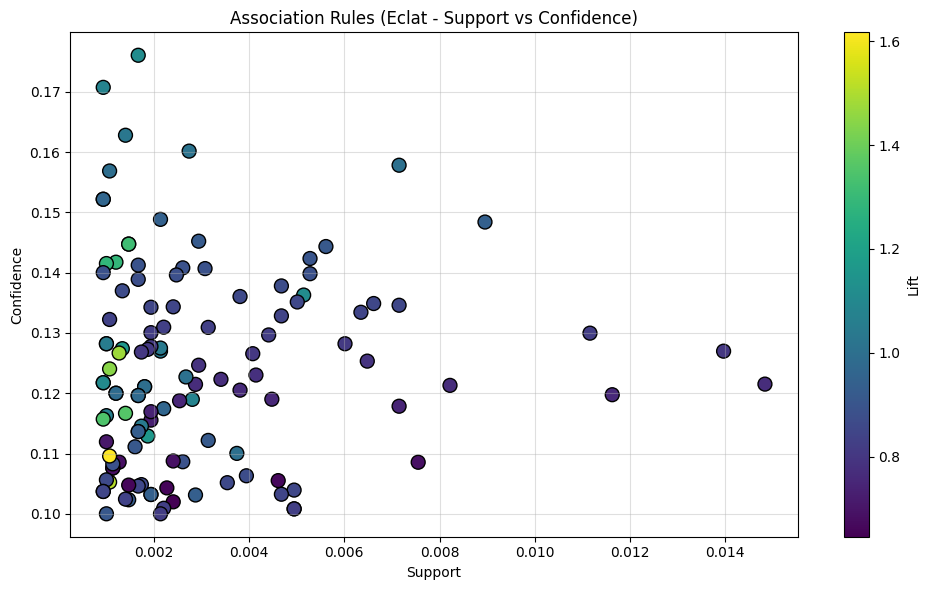

5568

In [5]:
def generate_association_rules(freq_itemsets, transactions, min_confidence):
    rules = []
    num_transactions = len(transactions)
    
    for itemset in freq_itemsets:
        if len(itemset) < 2:
            continue

        support_itemset = freq_itemsets[itemset] / num_transactions
        
        for antecedent in itemset:
            antecedent = frozenset([antecedent])  
            consequent = itemset - antecedent    
            
            if len(consequent) == 1 :
                consequent = frozenset(consequent)
                
                if antecedent in freq_itemsets and consequent in freq_itemsets:
                    support_antecedent = freq_itemsets[antecedent] / num_transactions
                    support_consequent = freq_itemsets[consequent] / num_transactions
                    confidence = support_itemset / support_antecedent
                    lift = confidence / support_consequent if support_consequent > 0 else 0
                    
                    if confidence >= min_confidence:
                        rules.append({
                            'antecedents': tuple(antecedent),
                            'consequents': tuple(consequent),
                            'support': support_itemset,
                            'confidence': confidence,
                            'lift': lift
                        })
    
    return rules

start_time = time.time()
start_memory = memory_usage()

rules = generate_association_rules(freq_itemsets, transactions, min_confidence)

if not rules:
    print("No association rules generated. Try lowering min_confidence or min_support.")
else:
    rules.sort(key=lambda x: x['support'], reverse=True)
    top_5_rules = rules[:5]

    rules_eclat_graph = pd.DataFrame(rules) 
    rules_eclat = pd.DataFrame(top_5_rules) 

    rules_eclat['support'] = rules_eclat['support'].round(6)
    rules_eclat['confidence'] = rules_eclat['confidence'].round(6)
    rules_eclat['lift'] = rules_eclat['lift'].round(6)

    rules_eclat_time = time.time() - start_time
    rules_eclat_memory = abs(memory_usage() - start_memory)

    # Print association rules
    print(f"\nAssociation Rules Execution Time: {rules_eclat_time:.4f} seconds")
    print(f"Association Rules Memory Usage: {rules_eclat_memory:.4f} MB")
    print("\nTop 5 Association Rules:\n")
    print(rules_eclat[['antecedents', 'consequents', 'support', 'confidence', 'lift']].to_string(index=True))

    # Plot association rules
    plt.figure(figsize=(10, 6))
    plt.scatter(
        rules_eclat_graph['support'], 
        rules_eclat_graph['confidence'], 
        c=rules_eclat_graph['lift'], 
        cmap='viridis', 
        s=100, 
        edgecolor='k'
    )
    plt.colorbar(label='Lift')
    plt.title('Association Rules (Eclat - Support vs Confidence)')
    plt.xlabel('Support')
    plt.ylabel('Confidence')
    plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.show()

gc.collect()

In [6]:
gc.collect()

print("Running Apriori...")
start_memory = memory_usage()

frequent_itemsets_apriori, apriori_time = measure_time(
    apriori, basket_df_int, min_support=0.001, use_colnames=True
)

num_itemsets = len(frequent_itemsets_apriori)
frequent_itemsets_apriori['itemset_size'] = frequent_itemsets_apriori['itemsets'].apply(len)
k_itemset_counts = frequent_itemsets_apriori.groupby('itemset_size').size()
top_5_support = frequent_itemsets_apriori.sort_values(by='support', ascending=False).head(5)
apriori_memory = abs(memory_usage() - start_memory)


print(f"Apriori Execution Time: {apriori_time:.4f} seconds")
print(f"Apriori Memory Usage: {apriori_memory:.4f} MB")
print(f"Total Number of Frequent Itemsets: {num_itemsets}")
print("\nNumber of k-itemsets:")
for k, count in k_itemset_counts.items():
    print(f"{k}-itemsets: {count}")

print(f"\nApriori Frequent Itemsets (Top 5):\n{top_5_support}")

# Top 5 frequent itemsets for itemset_size = 1
top_5_itemsets_size_1 = (
    frequent_itemsets_apriori[frequent_itemsets_apriori['itemset_size'] == 1]
    .sort_values(by='support', ascending=False)
    .head(5)
)

# Top 5 frequent itemsets for itemset_size = 2
top_5_itemsets_size_2 = (
    frequent_itemsets_apriori[frequent_itemsets_apriori['itemset_size'] == 2]
    .sort_values(by='support', ascending=False)
    .head(5)
)

# Top 5 frequent itemsets for itemset_size = 3
top_5_itemsets_size_3 = (
    frequent_itemsets_apriori[frequent_itemsets_apriori['itemset_size'] == 3]
    .sort_values(by='support', ascending=False)
    .head(5)
)

print("\nTop 5 Frequent Itemsets (Size 1):")
print(top_5_itemsets_size_1)

print("\nTop 5 Frequent Itemsets (Size 2):")
print(top_5_itemsets_size_2)

print("\nTop 5 Frequent Itemsets (Size 3):")
print(top_5_itemsets_size_3)

gc.collect()


Running Apriori...


c:\Users\Yin\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Apriori Execution Time: 3.3212 seconds
Apriori Memory Usage: 0.8945 MB
Total Number of Frequent Itemsets: 750

Number of k-itemsets:
1-itemsets: 149
2-itemsets: 592
3-itemsets: 9

Apriori Frequent Itemsets (Top 5):
      support            itemsets  itemset_size
146  0.157923        (whole milk)             1
90   0.122101  (other vegetables)             1
109  0.110005        (rolls/buns)             1
123  0.097106              (soda)             1
147  0.085879            (yogurt)             1

Top 5 Frequent Itemsets (Size 1):
      support            itemsets  itemset_size
146  0.157923        (whole milk)             1
90   0.122101  (other vegetables)             1
109  0.110005        (rolls/buns)             1
123  0.097106              (soda)             1
147  0.085879            (yogurt)             1

Top 5 Frequent Itemsets (Size 2):
      support                        itemsets  itemset_size
625  0.014837  (other vegetables, whole milk)             2
677  0.013968      

0

Association Rules Execution Time: 0.0024 seconds
Association Rules Memory Usage: 0.0000 MB
Top 5 Association Rules:
  antecedents         consequents   support  confidence      lift
0  (UHT-milk)  (other vegetables)  0.002139    0.100000  0.818993
1  (UHT-milk)        (whole milk)  0.002540    0.118750  0.751949
2      (beef)        (whole milk)  0.004678    0.137795  0.872548
3   (berries)  (other vegetables)  0.002673    0.122699  1.004899
4   (berries)        (whole milk)  0.002272    0.104294  0.660414


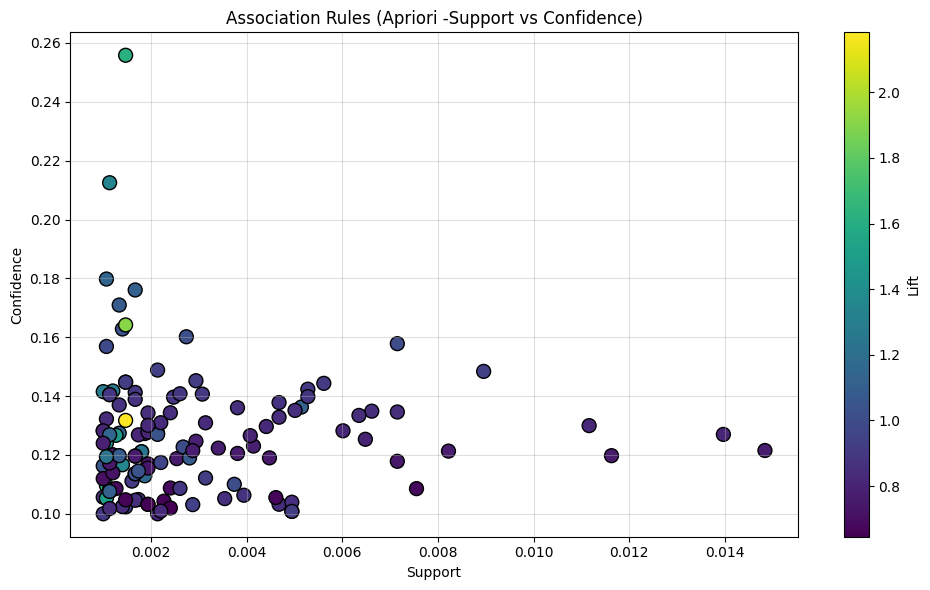

6000

In [7]:
gc.collect()

# Measure memory and time for Association Rules from Apriori
start_memory = memory_usage()
start_time = time.time()
rules_apriori = association_rules(frequent_itemsets_apriori, metric="confidence", min_threshold=0.1, num_itemsets=3)
rules_apriori_time = time.time() - start_time
rules_apriori_memory = abs(memory_usage() - start_memory)

print(f"Association Rules Execution Time: {rules_apriori_time:.4f} seconds")
print(f"Association Rules Memory Usage: {rules_apriori_memory:.4f} MB")
print("Top 5 Association Rules:")
print(rules_apriori[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

# Plot association rules
plt.figure(figsize=(10, 6))
plt.scatter(rules_apriori['support'], rules_apriori['confidence'], c=rules_apriori['lift'], cmap='viridis', s=100, edgecolor='k')
plt.colorbar(label='Lift')
plt.title('Association Rules (Apriori -Support vs Confidence)')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

gc.collect()

In [8]:
gc.collect()

print("\nRunning FP-Growth...")
start_memory = memory_usage()

frequent_itemsets_fpgrowth, fpgrowth_time = measure_time(
    fpgrowth, basket_df_int, min_support=0.001, use_colnames=True
)

num_itemsets = len(frequent_itemsets_fpgrowth)

frequent_itemsets_fpgrowth['itemset_size'] = frequent_itemsets_fpgrowth['itemsets'].apply(len)
k_itemset_counts = frequent_itemsets_fpgrowth.groupby('itemset_size').size()

top_5_support = frequent_itemsets_fpgrowth.sort_values(by='support', ascending=False).head(5)

fpgrowth_memory = abs(memory_usage() - start_memory)

print(f"FP-Growth Execution Time: {fpgrowth_time:.4f} seconds")
print(f"FP-Growth Memory Usage: {fpgrowth_memory:.4f} MB")
print(f"Total Number of Frequent Itemsets: {num_itemsets}")
print("\nNumber of k-itemsets:")
for k, count in k_itemset_counts.items():
    print(f"{k}-itemsets: {count}")

print(f"\nFP-Growth Frequent Itemsets (Top 5):\n{top_5_support}")

# Top 5 frequent itemsets for itemset_size = 1
top_5_itemsets_size_1 = (
    frequent_itemsets_fpgrowth[frequent_itemsets_fpgrowth['itemset_size'] == 1]
    .sort_values(by='support', ascending=False)
    .head(5)
)

# Top 5 frequent itemsets for itemset_size = 2
top_5_itemsets_size_2 = (
    frequent_itemsets_fpgrowth[frequent_itemsets_fpgrowth['itemset_size'] == 2]
    .sort_values(by='support', ascending=False)
    .head(5)
)

# Top 5 frequent itemsets for itemset_size = 3
top_5_itemsets_size_3 = (
    frequent_itemsets_fpgrowth[frequent_itemsets_fpgrowth['itemset_size'] == 3]
    .sort_values(by='support', ascending=False)
    .head(5)
)

print("\nTop 5 Frequent Itemsets (Size 1):")
print(top_5_itemsets_size_1)

print("\nTop 5 Frequent Itemsets (Size 2):")
print(top_5_itemsets_size_2)

print("\nTop 5 Frequent Itemsets (Size 3):")
print(top_5_itemsets_size_3)

gc.collect()


Running FP-Growth...


c:\Users\Yin\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


FP-Growth Execution Time: 11.1608 seconds
FP-Growth Memory Usage: 2.9141 MB
Total Number of Frequent Itemsets: 750

Number of k-itemsets:
1-itemsets: 149
2-itemsets: 592
3-itemsets: 9

FP-Growth Frequent Itemsets (Top 5):
     support            itemsets  itemset_size
0   0.157923        (whole milk)             1
17  0.122101  (other vegetables)             1
11  0.110005        (rolls/buns)             1
6   0.097106              (soda)             1
3   0.085879            (yogurt)             1

Top 5 Frequent Itemsets (Size 1):
     support            itemsets  itemset_size
0   0.157923        (whole milk)             1
17  0.122101  (other vegetables)             1
11  0.110005        (rolls/buns)             1
6   0.097106              (soda)             1
3   0.085879            (yogurt)             1

Top 5 Frequent Itemsets (Size 2):
      support                        itemsets  itemset_size
307  0.014837  (other vegetables, whole milk)             2
218  0.013968        (ro

23188

Association Rules Execution Time: 0.0025 seconds
Association Rules Memory Usage: 0.0117 MB

Top 5 Association Rules (FP-Growth):
     antecedents         consequents   support  confidence      lift
0       (pastry)        (whole milk)  0.006483    0.125323  0.793571
1  (salty snack)        (whole milk)  0.001938    0.103203  0.653502
2  (salty snack)        (rolls/buns)  0.001938    0.103203  0.938168
3  (salty snack)  (other vegetables)  0.002205    0.117438  0.961807
4       (yogurt)        (whole milk)  0.011161    0.129961  0.822940


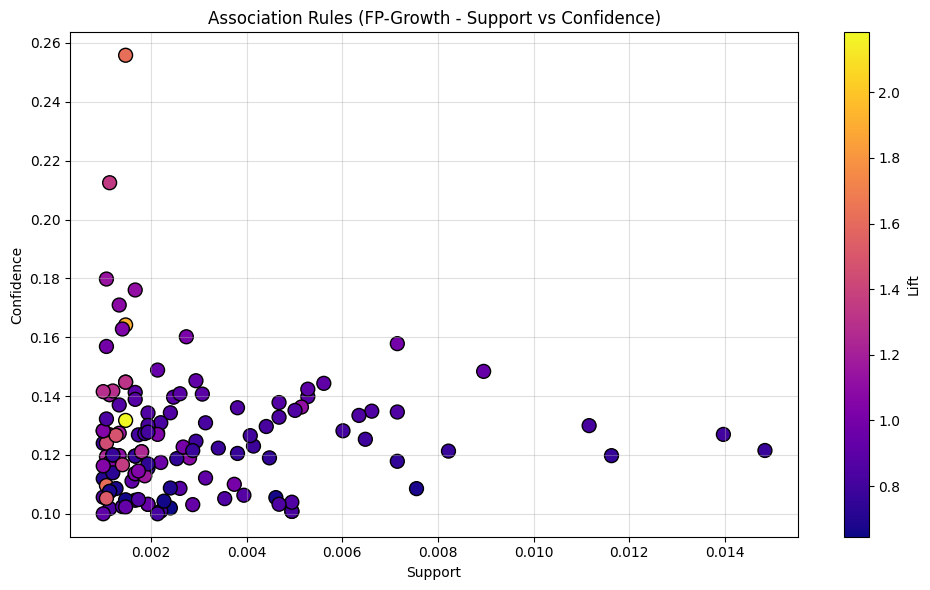

6015

In [9]:
# Measure memory and time for Association Rules from FPGrowth
start_memory = memory_usage()  # Reset baseline memory measurement
start_time = time.time()
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric="confidence", min_threshold=0.1, num_itemsets=3)
rules_fpgrowth_time = time.time() - start_time
rules_fpgrowth_memory = memory_usage() - start_memory 

print(f"Association Rules Execution Time: {rules_fpgrowth_time:.4f} seconds")
print(f"Association Rules Memory Usage: {rules_fpgrowth_memory:.4f} MB")
print("\nTop 5 Association Rules (FP-Growth):")
print(rules_fpgrowth[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

# Plot association rules from FP-Growth
plt.figure(figsize=(10, 6))
plt.scatter(rules_fpgrowth['support'], rules_fpgrowth['confidence'], c=rules_fpgrowth['lift'], cmap='plasma', s=100, edgecolor='k')
plt.colorbar(label='Lift')
plt.title('Association Rules (FP-Growth - Support vs Confidence)')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

gc.collect()

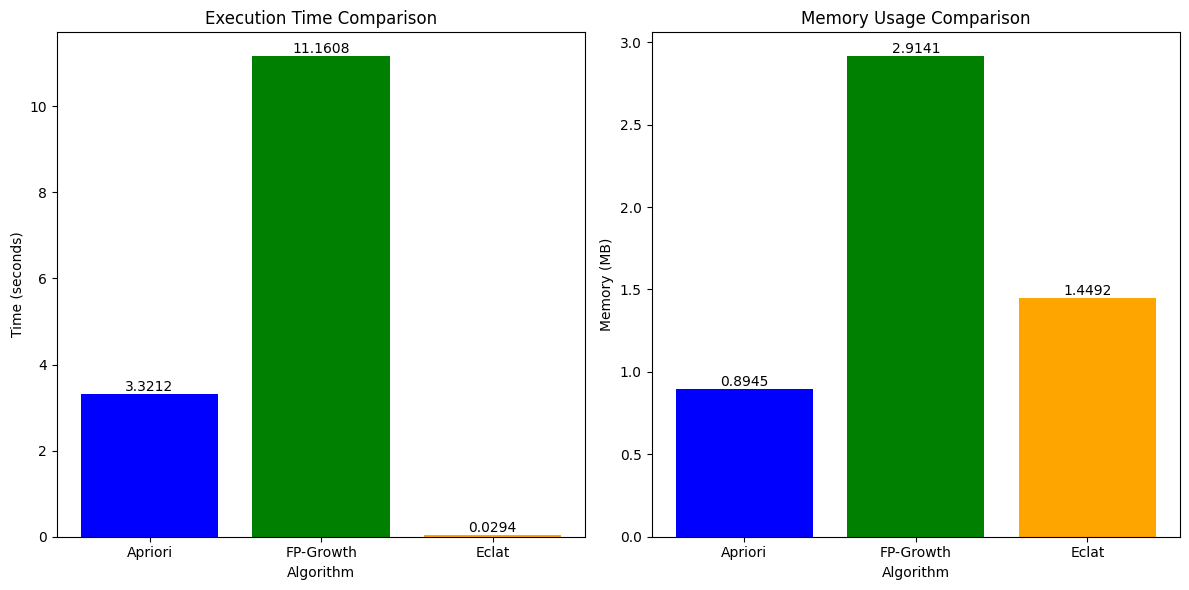

In [10]:
algorithms = ['Apriori', 'FP-Growth', 'Eclat']

execution_times = [apriori_time, fpgrowth_time, eclat_time]
memory_usage = [apriori_memory, fpgrowth_memory, eclat_memory]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].bar(algorithms, execution_times, color=['blue', 'green', 'orange'])
axes[0].set_title('Execution Time Comparison')
axes[0].set_ylabel('Time (seconds)')
axes[0].set_xlabel('Algorithm')
axes[0].bar_label(axes[0].containers[0], fmt='%.4f', label_type='edge')

axes[1].bar(algorithms, memory_usage, color=['blue', 'green', 'orange'])
axes[1].set_title('Memory Usage Comparison')
axes[1].set_ylabel('Memory (MB)')
axes[1].set_xlabel('Algorithm')
axes[1].bar_label(axes[1].containers[0], fmt='%.4f', label_type='edge')

plt.tight_layout()
plt.show()